In [2]:
from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from folium import folium
from folium.plugins import TimeSliderChoropleth
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import numpy as np
import geocoder
import re

from shapely.geometry import Point
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
%matplotlib inline

In [3]:
def get_lat_long(row, address = "Full Address", city = "CITY", state = "STATE"):
    string_list = []
    if row[address]:
        string_list.append(row[address])
    if row[city]:
        string_list.append(row[city])
    string_list.append("Los Angeles County")
    if row[state]:
        string_list.append(row[state])
    separator = ","
    full_string = separator.join(string_list)
    
    g = geocoder.arcgis(full_string)
    # Get latlng attribute from g
    # latlng is a list with two elements
    lat_lng_list = g.latlng
    #print(lat_lng_list)
    # Create default values for latitude and longitude
    latitude = 0.0
    longitude = 0.0
    # see if value returned by geocoder is within LA County
    # If so, replace default value with it
    if 33.6 <= lat_lng_list[0] <= 35.0:
        latitude = lat_lng_list[0]
    if -119.0 <= lat_lng_list[1] <= -117.6:
        longitude = lat_lng_list[1]
    # Populate the Lat and Long columns in the row
    #latitude = lat_lng_list[0]
    #longitude = lat_lng_list[1]
    row["Lat"] = latitude
    row["Long"] = longitude
    return row

In [4]:
#lat = re.compile('\d{2}\.\d*')
#long = re.compile('-\d*\.\d*')
# Regex with grouping to keep Lat and Long separate
latlong = re.compile('(\d{2}\.\d*), ?(-\d{3}\.\d*)')
#(34.0475, -118.323)

# Checks if Cross Street field is populated
# If so, combines with Address field and returns
# Otherwise returns original row
def combine_address_with_cross(row):
    if pd.notnull(row["Cross Street"]):
        combined_text = str(row["Address"]) + " and " + str(row["Cross Street"])
        row["Address"] = combined_text
        return row
    else:
        return row

# Checks if Location field has a null Lat/Long
# If so, runs combine_address_with_cross then geocodes result
# Returns geocoded row
def geocode_only_nulls(row):
    if row["Location"] == "(0.0, 0.0)":
        updated_row = combine_address_with_cross(row)
        geocoded_row = get_lat_long(updated_row, address = "Address", city = "Area Name", state = "STATE")
        return geocoded_row
    else:
        return row
        
# Takes string location and searches for Lat Long using regex
# Checks to be sure result is within LA County
#def split_lat_long(row):
#    lat_long_str = row["Location"]
#    print(lat_long_str)
#    latitude = lat.search(lat_long_str)
#    #print(latitude.group())
#    if latitude:
#        if 33.6 <= float(latitude.group()) <= 35.0:
#            row["Lat"] = latitude.group()
#    else:
#        row["Lat"] = "No Match"
#   longitude = long.search(lat_long_str)
#    #print(longitude.group())
#    if longitude:
#        if -119.0 <= float(longitude.group()) <= -117.6:
#            row["Long"] = longitude.group()
#    else:
#        row["Long"] = "No Match"
#    return row

# Takes string location and searches for Lat Long using regex
# Checks to be sure result is within LA County
def split_lat_long(row):
    lat_long_str = row["Location"]
    #print(lat_long_str)
    # Search Lat Long String with Regex
    latlongmatch = latlong.search(lat_long_str)
    # Check for match group 1 (Latitude)
    latitude = 0.0
    longitude = 0.0
    try:
        latitude = float(latlongmatch.group(1))
        #print("Latitude: " + str(latitude))
    except:
        pass
    # Check if returned latitude is within LA County Area
    try:
        if 33.6 <= latitude <= 35.0:
            row["Lat"] = latitude
    except:
        pass
    # Check for match group 2 (Longitude)
    try:
        longitude = float(latlongmatch.group(2))
        #print("Longitude: " + str(longitude))
    except:
        pass
    # Check if longitude is within LA County Area
    try:
        if -119.0 <= longitude <= -117.6:
            row["Long"] = longitude
    except:
        pass
    #print(str(row["Lat"]))
    #print(str(row["Long"]))
    return row

In [5]:
# Makes sure Lat Long Values are stored as floats
def convert_lat_long_to_float(row):
    row["Lat"] = float(row["Lat"])
    row["Long"] = float(row["Long"])
    return row

In [6]:
# Import arrest data from LAPD downloaded from City of LA Open Data Portal
raw_arrest_data = pd.read_csv("./Arrest_Data_from_2010_to_Present.csv", parse_dates = ["Arrest Date", "Time"])

In [7]:
raw_arrest_data.head()
#raw_arrest_data.shape
#raw_arrest_data["Charge Group Description"].unique()

,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location
0,191811472,2019-05-03,1700,18,Southeast,1802,23,F,B,NaN,NaN,M,653.22 PC,NaN,91ST,FIGUEROA,"(33.9543, -118.2827)"
1,5614161,2019-04-29,1040,8,West LA,842,41,M,H,3.0,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,NaN,"(34.0508, -118.4592)"
2,5615197,2019-04-30,0615,6,Hollywood,663,27,M,O,5.0,Burglary,F,459PC,BURGLARY,LA BREA,LEXINGTON,"(34.0907, -118.3384)"
3,5615701,2019-04-30,1100,9,Van Nuys,901,2,F,H,NaN,NaN,D,300(B)WIC,NaN,RAYMER,SEPULVEDA BL,"(34.2149, -118.4674)"
4,5615929,2019-04-30,1550,20,Olympic,2049,41,M,W,4.0,Aggravated Assault,F,245(A)(2)PC,ADW W/FIREARM,8TH ST,VERMONT,"(34.0578, -118.2916)"


In [8]:
raw_arrest_data["Charge Group Description"].unique()

array([nan, 'Robbery', 'Burglary', 'Aggravated Assault',
       'Miscellaneous Other Violations', 'Drunkeness', 'Larceny',
       'Liquor Laws', 'Narcotic Drug Laws', 'Disorderly Conduct',
       'Prostitution/Allied', 'Disturbing the Peace',
       'Driving Under Influence', 'Gambling', 'Sex (except rape/prst)',
       'Fraud/Embezzlement', 'Receive Stolen Property', 'Other Assaults',
       'Homicide', 'Weapon (carry/poss)', 'Vehicle Theft',
       'Against Family/Child', 'Forgery/Counterfeit',
       'Moving Traffic Violations', 'Non-Criminal Detention', 'Rape',
       'Federal Offenses', 'Pre-Delinquency'], dtype=object)

In [9]:
#Filter Raw Arrest Data to only DUI Incidents.
dui_arrest_data = raw_arrest_data[raw_arrest_data["Charge Group Description"] == 'Driving Under Influence']

In [10]:
# See how many we are left with
dui_arrest_data.shape

(120603, 17)

In [11]:
# Reset Index of Filtered Data
dui_arrest_data = dui_arrest_data.reset_index()

In [12]:
# Create empty rows to store Lat and Long
# Assign new row for state value
dui_arrest_data['Lat'] = np.nan
dui_arrest_data['Long'] = np.nan
dui_arrest_data = dui_arrest_data.assign(STATE="California")

In [13]:
# Confirm new rows added.
dui_arrest_data.shape

(120603, 21)

In [14]:
dui_arrest_data.head()

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE
0,95,191008773,2019-04-20,1830,10,West Valley,1049,28,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,BURBANK BL,WOODLEY AV,"(34.1717, -118.4757)",NaN,NaN,California
1,183,5478957,2018-11-22,0940,8,West LA,827,21,F,W,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,SAN VICENTE,BARRINGTON,"(34.0536, -118.4655)",NaN,NaN,California
2,202,5511360,2019-01-03,0116,7,Wilshire,717,39,M,B,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,400 N LA BREA AV,NaN,"(34.0783, -118.3441)",NaN,NaN,California
3,213,5523557,2019-01-18,0150,7,Wilshire,784,35,M,B,...,Driving Under Influence,F,23153(A)VC,DUI ALCOHOL CAUSING INJURY,WASHINGTON BL,REDONDO ST,"(34.0412, -118.3528)",NaN,NaN,California
4,240,5551051,2019-02-19,1130,1,Central,122,38,F,W,...,Driving Under Influence,M,23152(B)VC,DRUNK DRIVING .10 OR ABOVE,100 N HILL ST,NaN,"(34.0572, -118.2481)",NaN,NaN,California


In [15]:
# Attempt to pull Lat Long from String values.
dui_arrest_data = dui_arrest_data.apply(split_lat_long, axis = 1)

In [16]:
# Check for rows where Latitude is still null.
test_lat_long = dui_arrest_data[dui_arrest_data["Lat"].isnull()]
test_lat_long.shape

(187, 21)

In [17]:
# Rows missing a Latitude appear to be those with (0.0, 0.0)
test_lat_long.head()

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE
147,2124,5613213,2019-04-28,0220,9,Van Nuys,995,29,F,W,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,SAN DIEGO FY,GETTY DR,"(0.0, 0.0)",NaN,NaN,California
677,8481,5638044,2019-05-24,0347,17,Devonshire,1733,27,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,HAYVENHURST,REGAN FY,"(0.0, 0.0)",NaN,NaN,California
4119,44027,5757800,2019-09-26,2127,14,Pacific,1400,23,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,10 FY,405 FY,"(0.0, 0.0)",NaN,NaN,California
5191,58615,2464438,2010-09-03,0330,9,Van Nuys,902,34,M,H,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,SEPULVEDA,GILMORE,"(0.0, 0.0)",NaN,NaN,California
5230,61341,2235703,2010-02-20,0030,2,Rampart,224,40,M,W,...,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,LA VETA TERRACE DR,SUNSET BL,"(0.0, 0.0)",NaN,NaN,California


In [18]:
# Run function to geocode rows with (0.0, 0.0) Lat Long
dui_arrest_data = dui_arrest_data.apply(geocode_only_nulls, axis = 1)

In [19]:
# No longer have rows with Null Latitude
dui_arrest_data[dui_arrest_data["Lat"].isnull()]

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Lat,Long,STATE


In [20]:
# Make sure Lat Long values are float
dui_arrest_data = dui_arrest_data.apply(convert_lat_long_to_float, axis = 1)

In [21]:
dui_arrest_data["int_time"] = dui_arrest_data['Time'].astype(int)

In [22]:
dui_arrest_data.describe()

,index,Report ID,Area ID,Reporting District,Age,Charge Group Code,Lat,Long,int_time
count,1.206030e+05,1.206030e+05,120603.000000,120603.000000,120603.000000,120603.0,120603.000000,120603.000000,120603.000000
mean,8.380191e+05,4.069937e+06,11.307886,1179.200285,34.438231,22.0,34.095409,-118.363724,1117.277091
std,2.940283e+05,4.923199e+06,5.702602,572.085423,11.656282,0.0,0.107735,0.098771,900.166785
min,9.500000e+01,1.608103e+06,1.000000,100.000000,13.000000,22.0,33.706500,-118.666700,0.000000
25%,6.420675e+05,3.034826e+06,6.000000,667.000000,25.000000,22.0,34.027300,-118.437000,227.000000
50%,8.552080e+05,3.872868e+06,12.000000,1245.000000,31.000000,22.0,34.090800,-118.349500,1013.000000
75%,1.062324e+06,4.724706e+06,16.000000,1601.000000,42.000000,22.0,34.181700,-118.282050,2050.000000
max,1.314855e+06,1.921044e+08,21.000000,2199.000000,92.000000,22.0,34.706000,-117.716700,2400.000000


In [23]:
# Convert dataframe to geodataframe
dui_arrest_data_gdf = gpd.GeoDataFrame(
    dui_arrest_data, geometry=gpd.points_from_xy(dui_arrest_data.Long, dui_arrest_data.Lat))

# Convert Lat/Long data to projected Web Mercatur
dui_arrest_data_gdf.crs = {'init' :'epsg:4326'}
dui_arrest_data_gdf = dui_arrest_data_gdf.to_crs({'init': 'epsg:3857'})

In [24]:
# Filter to first 100 entries to run mapping test.
dui_arrest_data_gdf_for_mapping = dui_arrest_data_gdf.iloc[0:500]

In [25]:
# Load County outlines from LA Times
county = gpd.read_file("http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/counties-2012.geojson")
county = county.to_crs({'init': 'epsg:3857'})
# Filter to only display LA County
la_county = county[county["name"] == "Los Angeles"]
# Load City outline from LA Times
city = gpd.read_file("http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary/los-angeles-census-place-2012.geojson")
city = city.to_crs({'init': 'epsg:3857'})

In [26]:
city.head()

,kind,external_id,name,slug,set,metadata,resource_uri,geometry
0,Census Place (2012),Los Angeles,Los Angeles,los-angeles-census-place-2012,/1.0/boundary-set/census-places-2012/,"{'PCICBSA': 'Y', 'INTPTLAT': '+34.0193936', 'P...",/1.0/boundary/los-angeles-census-place-2012/,"MULTIPOLYGON (((-13210078.811 4053163.497, -13..."


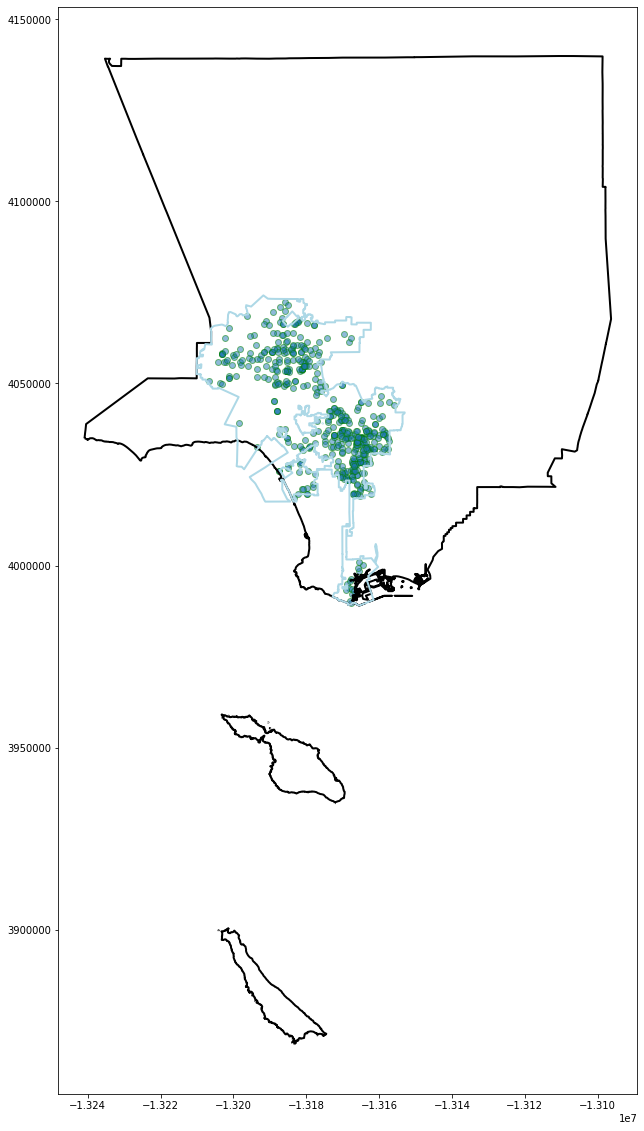

In [27]:
ax = la_county.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='k',linewidth = 2)

#la_county.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)

city.geometry.boundary.plot(color=None,edgecolor='lightblue',linewidth = 2,ax=ax)

dui_arrest_data_gdf_for_mapping.plot(figsize=(20, 20), alpha=0.5, edgecolor='green', ax = ax)

In [28]:
# Assembles List of Lists for Heat Map with Time plugin.
# Plugin currently not working, likely due to Leaflet update.
data_point_time_list=[]
# Create a list of 24 lists
# One for each hour of the day
for i in range(24):
    new_list = []
    data_point_time_list.append(new_list)
# Determine hour from Time and use as index to append to appropriate list
for index, row in dui_arrest_data_gdf.iterrows():
    time = row['Time']
    #print(time)
    hour = time[0:2]
    #Some data points list Midnight as 2400 while others list it as 0000
    if hour == '24':
        hour = '00'
    #print(int(hour))
    point = [row['Lat'],row['Long']]
    data_point_time_list[int(hour)].append(point)
    
#print(data_point_time_list)


In [29]:
my_map = folium.Map(location=[dui_arrest_data_gdf["Lat"].median(), dui_arrest_data_gdf["Long"].median()],
                       zoom_start=10, tiles='OpenStreetMap')

In [30]:
#HeatMapWithTime(data_point_time_list).add_to(my_map)

In [31]:
heat_data = [[row['Lat'],row['Long']] for index, row in dui_arrest_data_gdf_for_mapping.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(my_map)

# Display the map
my_map

In [32]:
new_map = folium.Map(location=[dui_arrest_data_gdf["Lat"].median(), dui_arrest_data_gdf["Long"].median()],
                       zoom_start=9, tiles='OpenStreetMap')

In [33]:
time_labels = ['Midnight - 1AM', '1AM to 2AM', '2AM to 3AM', '3AM to 4AM', '4AM to 5AM', '5AM to 6AM', '6AM to 7AM', '7AM to 8AM', '8AM to 9AM', '9AM to 10AM', '10AM to 11AM', '11AM to Noon', 'Noon to 1PM', '1PM - 2PM', '2PM - 3PM', '3PM - 4PM', '4PM - 5PM', '5PM - 6PM', '6PM - 7PM', '7PM - 8PM', '8PM - 9PM', '9PM - 10PM', '10PM - 11PM', '11PM - Midnight']
hm = plugins.HeatMapWithTime(data_point_time_list, index = time_labels, auto_play=True,max_opacity=0.8)

hm.add_to(new_map)
# Render the map
new_map.render()

In [34]:
# Jupyter Notebooks have difficulty displaying the map with so many data points. 
# Outputting to HTML file to view in browser separately.
new_map.save(outfile='index.html')

In [35]:
the_10 = gpd.read_file("./GISData/10_downtown_to_405.geojson")
the_10 = the_10.to_crs({'init': 'epsg:3857'})

In [36]:
the_10_buffered = the_10
the_10_buffered["geometry"] = the_10.geometry.buffer(150)

In [37]:
the_10_buffered.head()

,FullName,Type,Elevation,Surface,Status,DrivingDir,From_L,From_R,To_L,To_R,...,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len,geometry
0,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141601629,2015-05-07,571.813145,"POLYGON ((-13174714.263 4033380.996, -13174716..."
1,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241170773,2015-05-07,151.341975,"POLYGON ((-13176692.643 4033407.255, -13176705..."
2,Interstate 10,Freeway,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,241170751,2015-04-19,86.049217,"POLYGON ((-13170129.716 4033656.647, -13170144..."
3,Santa Monica Frwy,Freeway,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,241170751,2015-04-19,86.049217,"POLYGON ((-13170129.716 4033656.647, -13170144..."
4,None,Ramp,Surface,Paved,Unrestricted,Two Way,0,0,0,0,...,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241170699,2015-05-07,70.403895,"POLYGON ((-13175267.766 4033244.189, -13175282..."


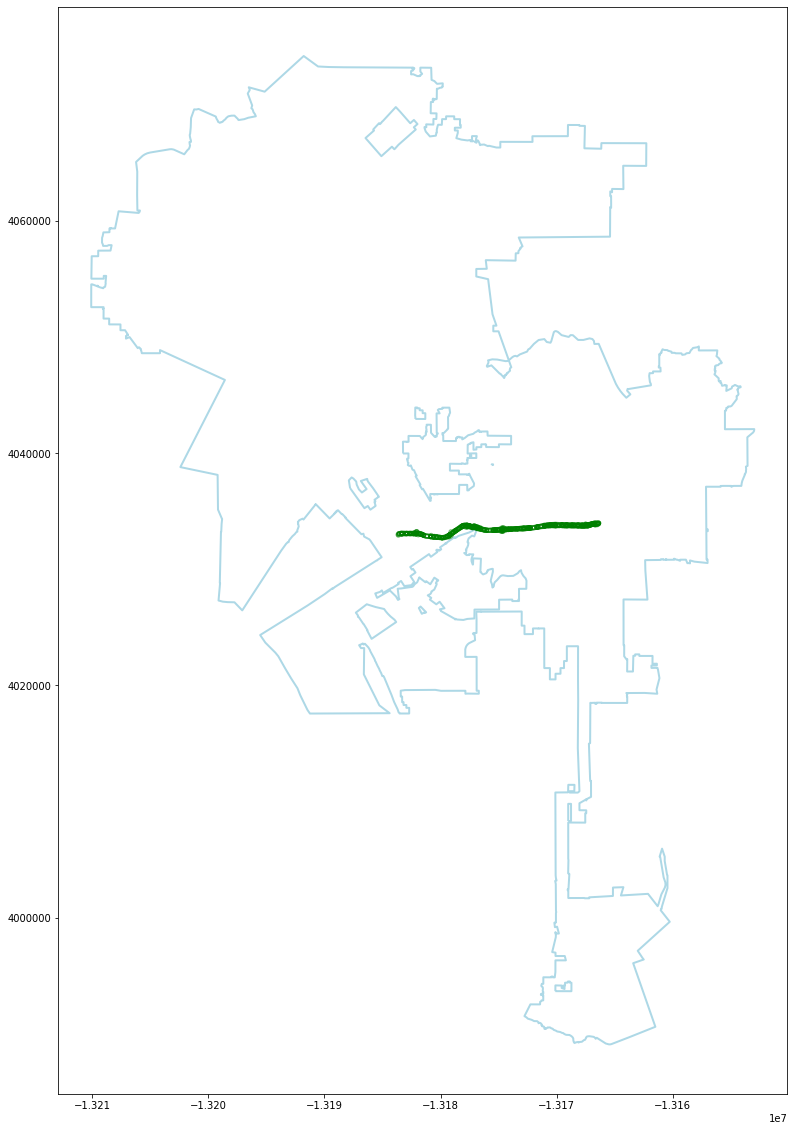

In [38]:
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

the_10_buffered.geometry.boundary.plot(alpha=0.5, edgecolor='green', ax = ax)

In [39]:
# Join DUI dataset to the freeway buffer.
join_duis_to_buffer = gpd.sjoin(dui_arrest_data_gdf, the_10_buffered, how='left', op='intersects', lsuffix='left', rsuffix='right')
# "Surface" field came from the buffer layer, so rows where it is null were outside the buffer
duis_on_the_10 = join_duis_to_buffer[join_duis_to_buffer["Surface"].notnull()]
print(duis_on_the_10.shape)
duis_on_the_10.head()

(28417, 56)


,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440


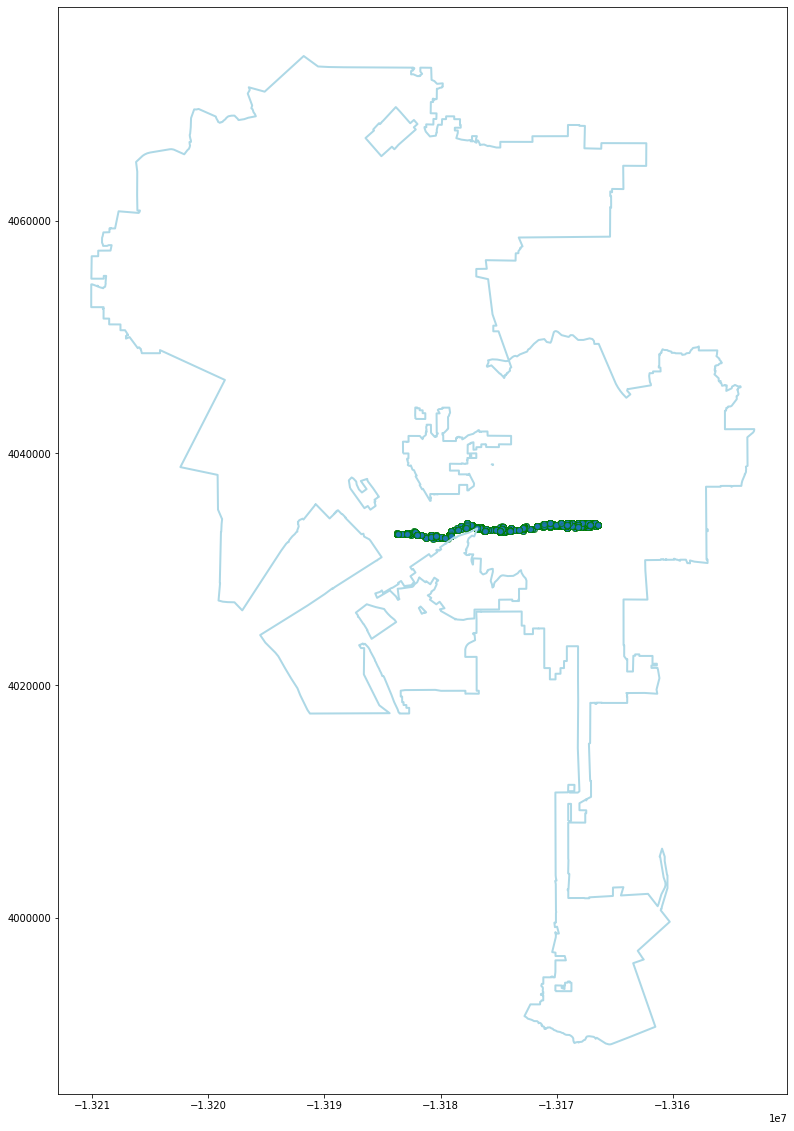

In [40]:
# Plot filtered dataset to make sure we're getting what we expect
ax = city.geometry.boundary.plot(figsize=(20, 20),color=None,edgecolor='lightblue',linewidth = 2)

duis_on_the_10.geometry.plot(alpha=0.5, edgecolor='green', ax = ax)

In [41]:
duis_on_the_10

,index,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,LCity_L,LCity_R,NameCat_L,NameCat_R,Accuracy,Jurisdicti,Source,SourceID,UpdateDate,Shape_len
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,241221193,2015-04-14,809.907539
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,142454034,2015-04-18,1131.852760
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141607343,2015-04-14,1031.813655
78,1455,5613205,2019-04-28,0425,3,Southwest,309,31,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,142454036,2015-04-18,1046.975440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,141606019,2015-04-19,1188.676021
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,None,None,50.0,UNKNOWN,TIGER Ramps And Free,141606009,2015-04-19,442.955575
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Secondary,Secondary,50.0,UNKNOWN,TIGER Ramps And Free,241229778,2015-04-19,1090.484000
120538,1314495,5609065,2019-04-24,0306,20,Olympic,2093,25,M,H,...,Los Angeles,Los Angeles,Primary,Primary,50.0,UNKNOWN,TIGER Ramps And Free,241229778,2015-04-19,1090.484000


In [42]:
duis_on_the_10["Arrest Date"] = duis_on_the_10["Arrest Date"].astype("datetime64")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


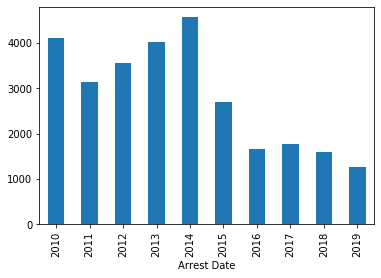

In [43]:
duis_on_the_10["Arrest Date"].groupby([duis_on_the_10["Arrest Date"].dt.year]).count().plot(kind="bar")

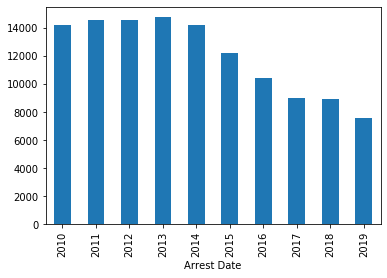

In [44]:
# Plot overall dui arrest data to compare with our area of interest.
dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().plot(kind="bar")

# There is an overall downward trend in DUI's during the same timeframe.
## Is the change in our area of interest similar to the overall trend?

In [45]:
total_dui_by_year = dui_arrest_data["Arrest Date"].groupby([dui_arrest_data["Arrest Date"].dt.year]).count().astype(float)
total_dui_by_year

Arrest Date
2010    14193.0
2011    14584.0
2012    14574.0
2013    14775.0
2014    14248.0
2015    12244.0
2016    10468.0
2017     8992.0
2018     8918.0
2019     7607.0
Name: Arrest Date, dtype: float64

In [46]:
# Calculate % change year over year for total DUI's
total_change = (total_dui_by_year.pct_change())*100
total_change

Arrest Date
2010          NaN
2011     2.754879
2012    -0.068568
2013     1.379168
2014    -3.566836
2015   -14.065132
2016   -14.505064
2017   -14.100115
2018    -0.822954
2019   -14.700606
Name: Arrest Date, dtype: float64

In [47]:
i10_duis_by_year = duis_on_the_10["Arrest Date"].groupby([duis_on_the_10["Arrest Date"].dt.year]).count().astype(float)
i10_duis_by_year

Arrest Date
2010    4106.0
2011    3135.0
2012    3567.0
2013    4014.0
2014    4568.0
2015    2703.0
2016    1671.0
2017    1785.0
2018    1603.0
2019    1265.0
Name: Arrest Date, dtype: float64

In [48]:
aoi_change = (i10_duis_by_year.pct_change())*100
aoi_change

Arrest Date
2010          NaN
2011   -23.648320
2012    13.779904
2013    12.531539
2014    13.801694
2015   -40.827496
2016   -38.179800
2017     6.822262
2018   -10.196078
2019   -21.085465
Name: Arrest Date, dtype: float64

In [49]:
yearly_totals = pd.concat([total_dui_by_year, total_change, i10_duis_by_year, aoi_change], axis=1)
yearly_totals.columns=['Total DUI', 'Total Change', 'AOI DUI', 'AOI Change']
yearly_totals['Year'] = yearly_totals.index

In [50]:
yearly_totals.dropna()

,Total DUI,Total Change,AOI DUI,AOI Change,Year
Arrest Date,,,,,
2011,14584.0,2.754879,3135.0,-23.648320,2011
2012,14574.0,-0.068568,3567.0,13.779904,2012
2013,14775.0,1.379168,4014.0,12.531539,2013
2014,14248.0,-3.566836,4568.0,13.801694,2014
2015,12244.0,-14.065132,2703.0,-40.827496,2015
2016,10468.0,-14.505064,1671.0,-38.179800,2016
2017,8992.0,-14.100115,1785.0,6.822262,2017
2018,8918.0,-0.822954,1603.0,-10.196078,2018
2019,7607.0,-14.700606,1265.0,-21.085465,2019


In [51]:
yearly_totals["AOI DUI"].dtype

dtype('float64')

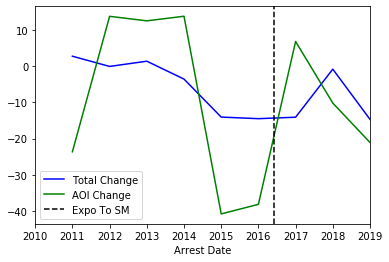

In [52]:
yearly_totals["Total Change"].plot(kind = "line", color='blue')
yearly_totals["AOI Change"].plot(kind = "line", color= 'green')
# Expo Line reached Santa Monica in May of 2016
# 5/12 = 0.4166666667 so using decimal to place marker line part way through the year.
plt.axvline(x=2016.4166666667, color= 'black', label = 'Expo To SM', linestyle = "--")
plt.legend()

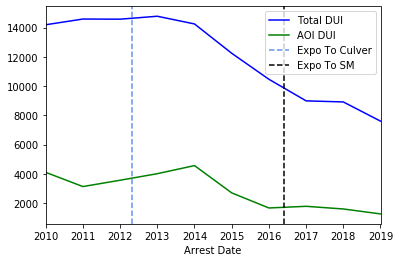

In [58]:
yearly_totals["Total DUI"].plot(kind = "line", color='blue')
yearly_totals["AOI DUI"].plot(kind = "line", color= 'green')
# Expo Line reached Santa Monica in May of 2016
# 5/12 = 0.4166666667 so using decimal to place marker line part way through the year.
plt.axvline(x=2012.3333333333, color= 'cornflowerblue', label = 'Expo To Culver', linestyle = "--")
plt.axvline(x=2016.4166666667, color= 'black', label = 'Expo To SM', linestyle = "--")

plt.legend(loc='upper right')

# Changes in the AOI are more extreme that overall changes. 
## The downward trend in DUI's also appears to start prior to the Expo Line reaching Santa Monica.
## Is this trend unique to this section of freeway?
## If not, is the change on the 10 Freeway comprable to changes on other freeway segments?

In [59]:
# Need to isolate DUI's in buffers of other freeways.
# Plot trend in each dataset together to compare.
# If Expo line isn't the source of the trend, what else could be a factor?
# How does the timing line up with the rise of Rideshare services?

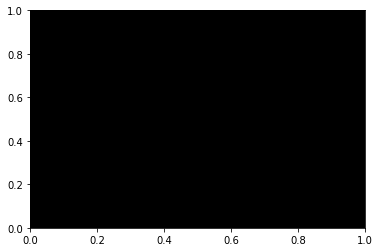

In [ ]:
#https://data.ca.gov/dataset/annual-average-daily-traffic-volumes
# Compare trend to traffic count trend over those years to see if there is another explanation
# Compare overall trend on freeways as well as trend on the 10